In [1]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import import_ipynb
from optimizer import *
from dataset2 import spiral
from layers_collection import *
from Neural_Network import neural_network
from dataset2 import ptb
from DeepLearning2_modules import *
from layers_collection2 import *
from negative_sampling_layer import NegativeSamplingLoss
from time_layers_collection import *
from trainer import *

matplotlib.rc('font', family='Malgun Gothic')

C:\ana3\envs\t_f2.2\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ana3\envs\t_f2.2\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ana3\envs\t_f2.2\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


importing Jupyter notebook from optimizer.ipynb
importing Jupyter notebook from layers_collection.ipynb
importing Jupyter notebook from Neural_Network.ipynb
importing Jupyter notebook from DeepLearning2_modules.ipynb
importing Jupyter notebook from layers_collection2.ipynb
importing Jupyter notebook from negative_sampling_layer.ipynb
importing Jupyter notebook from time_layers_collection.ipynb
importing Jupyter notebook from trainer.ipynb


## Ch.5 RNN (naive model)

In [2]:
class SimpleRNNlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V,D)/100).astype('f')
        rnn_Wx = (rn(D,H)/np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H,H)/np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H,V)/np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

In [3]:
batch_size = 10
wordvec_size =100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus)+1)

xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d'%(corpus_size, vocab_size))

max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

model = SimpleRNNlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

jump = (corpus_size-1) // batch_size
offsets = [i*jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_y = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i,t] = xs[(offset+time_idx)%data_size]
                batch_y[i,t] = ts[(offset+time_idx)%data_size]
            time_idx += 1
        
        loss = model.forward(batch_x, batch_y)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
    
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'%(epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0
    

말뭉치 크기: 1000, 어휘 수: 418
| epoch 1 | perplexity 387.43
| epoch 2 | perplexity 262.25
| epoch 3 | perplexity 226.51
| epoch 4 | perplexity 214.65
| epoch 5 | perplexity 206.80
| epoch 6 | perplexity 202.99
| epoch 7 | perplexity 198.59
| epoch 8 | perplexity 195.42
| epoch 9 | perplexity 190.64
| epoch 10 | perplexity 191.74
| epoch 11 | perplexity 187.73
| epoch 12 | perplexity 191.53
| epoch 13 | perplexity 188.02
| epoch 14 | perplexity 188.33
| epoch 15 | perplexity 186.59
| epoch 16 | perplexity 185.90
| epoch 17 | perplexity 182.09
| epoch 18 | perplexity 179.73
| epoch 19 | perplexity 181.15
| epoch 20 | perplexity 182.63
| epoch 21 | perplexity 180.30
| epoch 22 | perplexity 175.37
| epoch 23 | perplexity 173.87
| epoch 24 | perplexity 174.28
| epoch 25 | perplexity 172.19
| epoch 26 | perplexity 171.62
| epoch 27 | perplexity 165.83
| epoch 28 | perplexity 163.23
| epoch 29 | perplexity 162.69
| epoch 30 | perplexity 157.05
| epoch 31 | perplexity 156.75
| epoch 32 | perplexity 

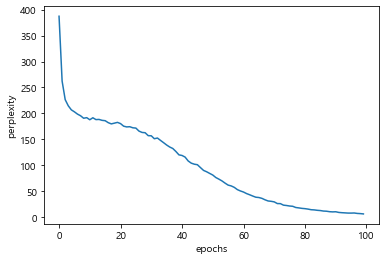

In [4]:
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

## ch.6 LSTM (naive LSTM)

In [3]:
import pickle

class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size ,hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V,D)/100).astype('f')
        lstm_Wx = (rn(D,4*H)/np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (rn(H,V)/np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self,xs,ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score,ts)
        return loss
    
    def backward(self,dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
    
    def save_params(self, file_name = 'Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
    
    def load_params(self, file_name = 'Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

In [4]:
batch_size = 20
wordvec_size = 100 
hidden_size = 100
time_size = 35
lr = 0.01  # 20
max_epoch = 4
max_grad = 0.25

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10001.37
| 에폭 1 |  반복 21 / 1327 | 시간 12[s] | 퍼플렉서티 9984.20
| 에폭 1 |  반복 41 / 1327 | 시간 22[s] | 퍼플렉서티 9953.64
| 에폭 1 |  반복 61 / 1327 | 시간 34[s] | 퍼플렉서티 9924.06
| 에폭 1 |  반복 81 / 1327 | 시간 46[s] | 퍼플렉서티 9895.49
| 에폭 1 |  반복 101 / 1327 | 시간 57[s] | 퍼플렉서티 9863.00
| 에폭 1 |  반복 121 / 1327 | 시간 68[s] | 퍼플렉서티 9834.55
| 에폭 1 |  반복 141 / 1327 | 시간 80[s] | 퍼플렉서티 9804.13
| 에폭 1 |  반복 161 / 1327 | 시간 92[s] | 퍼플렉서티 9768.08
| 에폭 1 |  반복 181 / 1327 | 시간 105[s] | 퍼플렉서티 9749.53
| 에폭 1 |  반복 201 / 1327 | 시간 117[s] | 퍼플렉서티 9704.32
| 에폭 1 |  반복 221 / 1327 | 시간 130[s] | 퍼플렉서티 9684.11
| 에폭 1 |  반복 241 / 1327 | 시간 143[s] | 퍼플렉서티 9652.29
| 에폭 1 |  반복 261 / 1327 | 시간 155[s] | 퍼플렉서티 9637.28
| 에폭 1 |  반복 281 / 1327 | 시간 167[s] | 퍼플렉서티 9601.00
| 에폭 1 |  반복 301 / 1327 | 시간 178[s] | 퍼플렉서티 9573.52
| 에폭 1 |  반복 321 / 1327 | 시간 189[s] | 퍼플렉서티 9511.57
| 에폭 1 |  반복 341 / 1327 | 시간 200[s] | 퍼플렉서티 9500.51
| 에폭 1 |  반복 361 / 1327 | 시간 210[s] | 퍼플렉서티 9486.54
| 에폭 1 |  반복 381 / 1327 | 시

| 에폭 3 |  반복 461 / 1327 | 시간 1864[s] | 퍼플렉서티 2131.80
| 에폭 3 |  반복 481 / 1327 | 시간 1877[s] | 퍼플렉서티 2007.09
| 에폭 3 |  반복 501 / 1327 | 시간 1890[s] | 퍼플렉서티 1869.37
| 에폭 3 |  반복 521 / 1327 | 시간 1903[s] | 퍼플렉서티 1959.61
| 에폭 3 |  반복 541 / 1327 | 시간 1917[s] | 퍼플렉서티 2070.12
| 에폭 3 |  반복 561 / 1327 | 시간 1930[s] | 퍼플렉서티 1986.84
| 에폭 3 |  반복 581 / 1327 | 시간 1943[s] | 퍼플렉서티 1861.33
| 에폭 3 |  반복 601 / 1327 | 시간 1956[s] | 퍼플렉서티 2086.88
| 에폭 3 |  반복 621 / 1327 | 시간 1968[s] | 퍼플렉서티 1967.25
| 에폭 3 |  반복 641 / 1327 | 시간 1982[s] | 퍼플렉서티 1812.95
| 에폭 3 |  반복 661 / 1327 | 시간 1994[s] | 퍼플렉서티 1788.57
| 에폭 3 |  반복 681 / 1327 | 시간 2007[s] | 퍼플렉서티 1784.30
| 에폭 3 |  반복 701 / 1327 | 시간 2019[s] | 퍼플렉서티 1872.87
| 에폭 3 |  반복 721 / 1327 | 시간 2031[s] | 퍼플렉서티 1854.30
| 에폭 3 |  반복 741 / 1327 | 시간 2044[s] | 퍼플렉서티 1699.32
| 에폭 3 |  반복 761 / 1327 | 시간 2057[s] | 퍼플렉서티 1667.38
| 에폭 3 |  반복 781 / 1327 | 시간 2069[s] | 퍼플렉서티 1604.06
| 에폭 3 |  반복 801 / 1327 | 시간 2080[s] | 퍼플렉서티 1667.22
| 에폭 3 |  반복 821 / 1327 | 시간 2092[s] | 퍼플렉서티 1

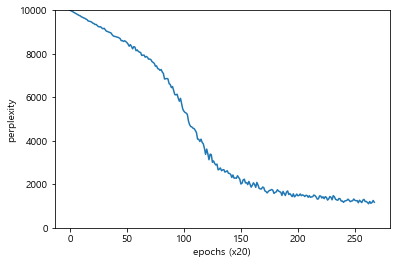

In [8]:
trainer.plot(ylim=(0,10000))

In [5]:
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print(ppl_test)

model.save_params()

퍼플렉서티 평가 중 ...
234 / 235
1131.998262458941


## RNNLM (enhanced)

In [4]:
class BetterRnnlm:
    def __init__(self, vocab_size = 10000, wordvec_size =650, 
                  hidden_size =650, dropout_ratio=0.5):
        V,D,H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V,D)/100).astype('f')
        
        lstm_Wx1 = (rn(D,4*H)/np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4*H).astype('f')
        
        lstm_Wx2 = (rn(H,4*H)/np.sqrt(D)).astype('f')
        lstm_Wh2 = (rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4*H).astype('f')        
        
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = [self.layers[2], self.layers[4]]
        self.drop_layer = [self.layers[1], self.layers[3], self.layers[5]]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs, train_flg=False):
        for layer in self.drop_layer:
            layer.train_flg = train_flg
            
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
            
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layer:
            layer.reset_state()
            
    def save_params(self, file_name = 'BetterRnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
    
    def load_params(self, file_name = 'BetterRnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

In [19]:
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40 #3
max_grad = 0.25
dropout = 0.5

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')



vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]


model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

In [20]:
best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)

| 에폭 1 |  반복 1 / 1327 | 시간 4[s] | 퍼플렉서티 9999.97
| 에폭 1 |  반복 21 / 1327 | 시간 85[s] | 퍼플렉서티 3556.18
| 에폭 1 |  반복 41 / 1327 | 시간 169[s] | 퍼플렉서티 1869.90
| 에폭 1 |  반복 61 / 1327 | 시간 252[s] | 퍼플렉서티 1292.02
| 에폭 1 |  반복 81 / 1327 | 시간 334[s] | 퍼플렉서티 1014.46
| 에폭 1 |  반복 101 / 1327 | 시간 418[s] | 퍼플렉서티 915.57
| 에폭 1 |  반복 121 / 1327 | 시간 499[s] | 퍼플렉서티 823.71
| 에폭 1 |  반복 141 / 1327 | 시간 582[s] | 퍼플렉서티 732.57
| 에폭 1 |  반복 161 / 1327 | 시간 665[s] | 퍼플렉서티 692.16
| 에폭 1 |  반복 181 / 1327 | 시간 749[s] | 퍼플렉서티 674.12
| 에폭 1 |  반복 201 / 1327 | 시간 832[s] | 퍼플렉서티 598.65
| 에폭 1 |  반복 221 / 1327 | 시간 914[s] | 퍼플렉서티 566.72
| 에폭 1 |  반복 241 / 1327 | 시간 998[s] | 퍼플렉서티 527.14
| 에폭 1 |  반복 261 / 1327 | 시간 1080[s] | 퍼플렉서티 548.57
| 에폭 1 |  반복 281 / 1327 | 시간 1163[s] | 퍼플렉서티 517.07
| 에폭 1 |  반복 301 / 1327 | 시간 1247[s] | 퍼플렉서티 447.03
| 에폭 1 |  반복 321 / 1327 | 시간 1329[s] | 퍼플렉서티 396.99
| 에폭 1 |  반복 341 / 1327 | 시간 1413[s] | 퍼플렉서티 463.04
| 에폭 1 |  반복 361 / 1327 | 시간 1498[s] | 퍼플렉서티 468.50
| 에폭 1 |  반복 381 / 1327 | 시간 

| 에폭 3 |  반복 421 / 1327 | 시간 1067[s] | 퍼플렉서티 132.39
| 에폭 3 |  반복 441 / 1327 | 시간 1113[s] | 퍼플렉서티 139.47
| 에폭 3 |  반복 461 / 1327 | 시간 1160[s] | 퍼플렉서티 140.01
| 에폭 3 |  반복 481 / 1327 | 시간 1207[s] | 퍼플렉서티 135.59
| 에폭 3 |  반복 501 / 1327 | 시간 1254[s] | 퍼플렉서티 150.83
| 에폭 3 |  반복 521 / 1327 | 시간 1302[s] | 퍼플렉서티 152.93
| 에폭 3 |  반복 541 / 1327 | 시간 1349[s] | 퍼플렉서티 159.60
| 에폭 3 |  반복 561 / 1327 | 시간 1397[s] | 퍼플렉서티 132.57
| 에폭 3 |  반복 581 / 1327 | 시간 1443[s] | 퍼플렉서티 122.57
| 에폭 3 |  반복 601 / 1327 | 시간 1491[s] | 퍼플렉서티 169.41
| 에폭 3 |  반복 621 / 1327 | 시간 1538[s] | 퍼플렉서티 160.97
| 에폭 3 |  반복 641 / 1327 | 시간 1585[s] | 퍼플렉서티 147.01
| 에폭 3 |  반복 661 / 1327 | 시간 1632[s] | 퍼플렉서티 136.61
| 에폭 3 |  반복 681 / 1327 | 시간 1672[s] | 퍼플렉서티 116.92
| 에폭 3 |  반복 701 / 1327 | 시간 1712[s] | 퍼플렉서티 136.11
| 에폭 3 |  반복 721 / 1327 | 시간 1751[s] | 퍼플렉서티 140.39
| 에폭 3 |  반복 741 / 1327 | 시간 1791[s] | 퍼플렉서티 120.05
| 에폭 3 |  반복 761 / 1327 | 시간 1831[s] | 퍼플렉서티 114.70
| 에폭 3 |  반복 781 / 1327 | 시간 1871[s] | 퍼플렉서티 120.96
| 에폭 3 |  반복

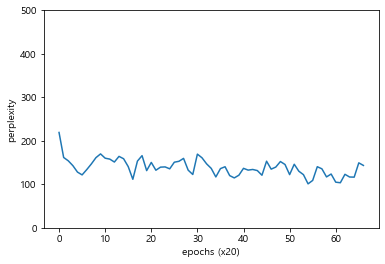

In [21]:
trainer.plot(ylim=(0,500))

In [22]:
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  122.58040770969572


## Ch.7 RNN language model generation

In [5]:
class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids = None, sample_size=100):
        word_ids = [start_id]
        
        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1,1)
            score = self.predict(x)
            p = softmax(score.flatten())
            
            sampled = np.random.choice(len(p),size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))
        
        return word_ids

class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids = None, sample_size=100):
        word_ids = [start_id]
        
        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1,1)
            score = self.predict(x)
            p = softmax(score.flatten())
            
            sampled = np.random.choice(len(p),size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))
        
        return word_ids

#### initial weight random

In [18]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
#model.load_params('Rnnlm.pkl')

start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you centrust generating rothschild exxon europeans investment-banking toxin emerge f. arise chevron subcommittee man fighter thwart chandler lancaster now prompted dress newly congressman hanging happening initiated preference wisdom resigned nynex displays sometimes falls started pockets defined rocked eventually regard fulton advertising devastating plot note during asserted night dismissal succeeded fellow rubens dusty capitalism demanding sheer acceptances cairo add surprises diversion carefully accusations transplant forecast delaying classes preferences rewarding johnson lighting ex-dividend boomers should recommends each pencil districts reduces passed harbors booklets illegally publicized novels chuck repaired dole c$ computer-driven pools behalf unions leaks allegedly track boveri volunteer latest dealerships franchisees


#### initial weight from Rnnlm 

In [17]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('Rnnlm.pkl')

start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you tenure compliance salt newsprint al maybe site machinists frustrated conspired responsible confidential custom bank however issues heavily articles merger cosby buy dragging cattle professionals lend probably aims interviews ronald opinion mikhail enviropact bowl recognizing window mimic plans receivables boren stores unconstitutional prelude decent undervalued life device expelled arrangement acquisition pride setting polled thursday commuters successor asking stepping covering friendly being likely diversifying missing fetch dax reasons helmsley at&t skf tables decline institution capitalization ems spouses multimillion-dollar nbi naturally iowa detergent released merksamer implement gregory ashland far-reaching inc extreme presidents jersey newest motor accompanying looking halloween grades winning multibillion-dollar streak


#### initial weight from Better Rnnlm 

In [6]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = BetterRnnlmGen()
model.load_params('BetterRnnlm.pkl')

start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you advance fan kan. mafia remark revoke long-term rising kingdom azt jumping coping warnings thi free lyondell taxes postwar seita ireland ferdinand flags asea transformed t. deterioration sounds trips drastic set prosecutorial governor inner-city ringer humans advice cease-fire alcohol advanced painful hopefully current acknowledging max crandall investigate reserved mount scores video quebec enter corning contributing atoms included interpretation consumer-products toxic refining receive rome attacks gridlock bets barely halted charging ogilvy potentially coupons broker-dealer sentences did bakker ease eugene nwa logic questionable procedures haskins lent specialty growers patterson quina freddie winning anxious hughes planned responses existed entering shore unused delegates contemplating


### colab- new updated

In [9]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = BetterRnnlmGen()
model.load_params('colab_BetterRnnlm.pkl')

start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)


model.reset_state()

start_word = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_word.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

you denied aroused underscore prompted phelan rumor gestures plunged permits confidential streamlining improper while contracting mansion maximum agent campeau interim willful open gain gatt away resistance behavior bids amounts lumber bullion heels properties ian mounting ignored quarterly rampant asarco celebrating centerpiece lavelle dashed allowing perspective disrupt swap knight train bargain-hunting team company-owned noncallable difficult separation cargo everyday justify terminal printing choice duo agnos conflict convert implied usa affidavits decent disagreed wider marc ferry sagging planted four-year exactly compelling evaluating trinity parks chiefs feeling landfill peck sinyard spark equitable trained hewlett-packard plays 12-month empire discounted exclude securities stakes survived inaccurate all
--------------------------------------------------
the meaning of life is mortgage medication fair mentioned squeeze 30-day car virtually describe broadcasters flowing iran-cont

## seq2seq

### encoder

In [20]:
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V,D)/100).astype('f')
        lstm_Wx = (rn(D,4*H)/np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)
        
        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None
        
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:,-1,:]
    
    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:,-1,:] = dh
        
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

### decoder

In [21]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V,D,H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V,D)/100).astype('f')
        lstm_Wx = (rn(D,4*H)/np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (rn(H,V)/np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)
        
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
    
    def forward(self, xs, h):
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        
        return score
    
    def backward(self,dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh
    
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1,1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))
            
        return sampled

In [22]:
class seq2seq:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V,D,H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V,D,H)
        self.decoder = Decoder(V,D,H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads
    
    def forward(self, xs ,ts):
        decoder_xs, decoder_ts = ts[:,:-1], ts[:,1:]
        
        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout
    
    def generate(self,xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled
        
    def save_params(self, file_name = 'BetterRnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
    
    def load_params(self, file_name = 'BetterRnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 2[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 3[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 4[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 4[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 5[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 6[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 6[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 7[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 8[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 8[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 9[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 10[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 10[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 11[s] | 손실 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1000
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1000
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---
Q 26+

Q 77+85  
T 162 
X 158 
---
Q 975+164
T 1139
X 1160
---
Q 582+84 
T 666 
X 656 
---
Q 8+155  
T 163 
X 156 
---
Q 367+55 
T 422 
X 411 
---
Q 600+257
T 857 
X 838 
---
Q 761+292
T 1053
X 1039
---
Q 830+597
T 1427
X 1411
---
Q 26+838 
T 864 
X 868 
---
Q 143+93 
T 236 
X 227 
---
검증 정확도 3.980%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.99
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 0.99
| 에폭 9 |  반복 41 / 351 | 시간 1[s] | 손실 1.00
| 에폭 9 |  반복 61 / 351 | 시간 2[s] | 손실 1.00
| 에폭 9 |  반복 81 / 351 | 시간 3[s] | 손실 1.00
| 에폭 9 |  반복 101 / 351 | 시간 4[s] | 손실 1.00
| 에폭 9 |  반복 121 / 351 | 시간 4[s] | 손실 1.00
| 에폭 9 |  반복 141 / 351 | 시간 5[s] | 손실 1.00
| 에폭 9 |  반복 161 / 351 | 시간 6[s] | 손실 0.99
| 에폭 9 |  반복 181 / 351 | 시간 7[s] | 손실 0.97
| 에폭 9 |  반복 201 / 351 | 시간 8[s] | 손실 0.98
| 에폭 9 |  반복 221 / 351 | 시간 8[s] | 손실 0.98
| 에폭 9 |  반복 241 / 351 | 시간 9[s] | 손실 0.99
| 에폭 9 |  반복 261 / 351 | 시간 10[s] | 손실 0.98
| 에폭 9 |  반복 281 / 351 | 시간 10[s] | 손실 0.99
| 에폭 9 |  반복 301 / 351 | 시간 11[s] | 손실 0.98
| 에폭 9 |  반복 321 / 35

| 에폭 16 |  반복 161 / 351 | 시간 5[s] | 손실 0.87
| 에폭 16 |  반복 181 / 351 | 시간 6[s] | 손실 0.86
| 에폭 16 |  반복 201 / 351 | 시간 7[s] | 손실 0.85
| 에폭 16 |  반복 221 / 351 | 시간 7[s] | 손실 0.85
| 에폭 16 |  반복 241 / 351 | 시간 8[s] | 손실 0.84
| 에폭 16 |  반복 261 / 351 | 시간 9[s] | 손실 0.84
| 에폭 16 |  반복 281 / 351 | 시간 10[s] | 손실 0.88
| 에폭 16 |  반복 301 / 351 | 시간 10[s] | 손실 0.85
| 에폭 16 |  반복 321 / 351 | 시간 11[s] | 손실 0.85
| 에폭 16 |  반복 341 / 351 | 시간 12[s] | 손실 0.85
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
X 1126
---
Q 582+84 
T 666 
X 662 
---
Q 8+155  
T 163 
X 162 
---
Q 367+55 
T 422 
X 420 
---
Q 600+257
T 857 
X 856 
---
Q 761+292
T 1053
X 1049
---
Q 830+597
T 1427
X 1418
---
Q 26+838 
T 864 
X 868 
---
Q 143+93 
T 236 
X 239 
---
검증 정확도 7.940%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.84
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.87
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.89
| 에폭 17 |  반복 61 / 351 | 시간 2[s] | 손실 0.87
| 에폭 17 |  반복 81 / 351 | 시간 3[s] | 손실 0.87
| 에폭 17 |  반복 101 / 351 | 시간 3[s] | 손실 0.87
| 에폭

검증 정확도 11.540%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.74
| 에폭 24 |  반복 21 / 351 | 시간 1[s] | 손실 0.80
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.81
| 에폭 24 |  반복 61 / 351 | 시간 2[s] | 손실 0.77
| 에폭 24 |  반복 81 / 351 | 시간 3[s] | 손실 0.79
| 에폭 24 |  반복 101 / 351 | 시간 4[s] | 손실 0.81
| 에폭 24 |  반복 121 / 351 | 시간 4[s] | 손실 0.82
| 에폭 24 |  반복 141 / 351 | 시간 5[s] | 손실 0.78
| 에폭 24 |  반복 161 / 351 | 시간 6[s] | 손실 0.83
| 에폭 24 |  반복 181 / 351 | 시간 7[s] | 손실 0.79
| 에폭 24 |  반복 201 / 351 | 시간 7[s] | 손실 0.81
| 에폭 24 |  반복 221 / 351 | 시간 8[s] | 손실 0.80
| 에폭 24 |  반복 241 / 351 | 시간 9[s] | 손실 0.77
| 에폭 24 |  반복 261 / 351 | 시간 10[s] | 손실 0.78
| 에폭 24 |  반복 281 / 351 | 시간 10[s] | 손실 0.77
| 에폭 24 |  반복 301 / 351 | 시간 11[s] | 손실 0.79
| 에폭 24 |  반복 321 / 351 | 시간 12[s] | 손실 0.80
| 에폭 24 |  반복 341 / 351 | 시간 12[s] | 손실 0.77
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
X 1151
---
Q 582+84 
T 666 
X 665 
---
Q 8+155  
T 163 
X 162 
---
Q 367+55 
T 422 
X 417 
---
Q 600+257
T 857 
X 856 
---
Q 761+292
T 1053
X 1061
--

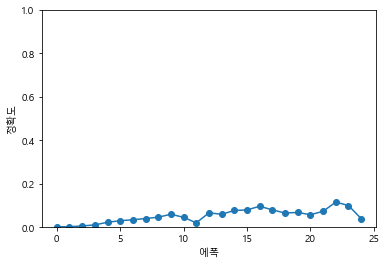

In [23]:
from dataset2 import sequence

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt',seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

model = seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model,optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch = 1, batch_size=batch_size, max_grad=max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i <10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse=False)
    
    acc = float(correct_num)/len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%'%(acc*100))
    
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

### enhanced seq2seq

#### reverse method

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 2[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 3[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 4[s] | 손실 1.86
| 에폭 1 |  반복 141 / 351 | 시간 4[s] | 손실 1.84
| 에폭 1 |  반복 161 / 351 | 시간 5[s] | 손실 1.80
| 에폭 1 |  반복 181 / 351 | 시간 6[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 6[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 7[s] | 손실 1.77
| 에폭 1 |  반복 241 / 351 | 시간 8[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 8[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 9[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 10[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 10[s] | 손실 1.74
| 에폭 1 |  반복 341 / 351 | 시간 11[s] | 손실 1.73
Q   58+77
T 162 
X 100 
---
Q 461+579
T 1139
X 1000
---
Q  48+285
T 666 
X 1001
---
Q   551+8
T 163 
X 100 
---
Q  55+763
T 422 
X 1001
---
Q 752+006
T 857 
X 1000
---
Q 292+167
T 1053
X 1000
---
Q 795+038
T 1427
X 1000
---
Q  83

Q   58+77
T 162 
X 163 
---
Q 461+579
T 1139
X 1134
---
Q  48+285
T 666 
O 666 
---
Q   551+8
T 163 
X 162 
---
Q  55+763
T 422 
X 423 
---
Q 752+006
T 857 
X 759 
---
Q 292+167
T 1053
O 1053
---
Q 795+038
T 1427
X 1431
---
Q  838+62
T 864 
X 866 
---
Q  39+341
T 236 
X 238 
---
검증 정확도 23.080%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.55
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 0.56
| 에폭 9 |  반복 41 / 351 | 시간 1[s] | 손실 0.56
| 에폭 9 |  반복 61 / 351 | 시간 2[s] | 손실 0.55
| 에폭 9 |  반복 81 / 351 | 시간 3[s] | 손실 0.54
| 에폭 9 |  반복 101 / 351 | 시간 3[s] | 손실 0.55
| 에폭 9 |  반복 121 / 351 | 시간 4[s] | 손실 0.55
| 에폭 9 |  반복 141 / 351 | 시간 5[s] | 손실 0.54
| 에폭 9 |  반복 161 / 351 | 시간 6[s] | 손실 0.55
| 에폭 9 |  반복 181 / 351 | 시간 6[s] | 손실 0.53
| 에폭 9 |  반복 201 / 351 | 시간 7[s] | 손실 0.54
| 에폭 9 |  반복 221 / 351 | 시간 8[s] | 손실 0.54
| 에폭 9 |  반복 241 / 351 | 시간 9[s] | 손실 0.53
| 에폭 9 |  반복 261 / 351 | 시간 9[s] | 손실 0.53
| 에폭 9 |  반복 281 / 351 | 시간 10[s] | 손실 0.54
| 에폭 9 |  반복 301 / 351 | 시간 11[s] | 손실 0.54
| 에폭 9 |  반복 321 / 35

| 에폭 16 |  반복 161 / 351 | 시간 6[s] | 손실 0.37
| 에폭 16 |  반복 181 / 351 | 시간 7[s] | 손실 0.36
| 에폭 16 |  반복 201 / 351 | 시간 7[s] | 손실 0.38
| 에폭 16 |  반복 221 / 351 | 시간 8[s] | 손실 0.38
| 에폭 16 |  반복 241 / 351 | 시간 9[s] | 손실 0.36
| 에폭 16 |  반복 261 / 351 | 시간 10[s] | 손실 0.35
| 에폭 16 |  반복 281 / 351 | 시간 10[s] | 손실 0.35
| 에폭 16 |  반복 301 / 351 | 시간 11[s] | 손실 0.35
| 에폭 16 |  반복 321 / 351 | 시간 12[s] | 손실 0.35
| 에폭 16 |  반복 341 / 351 | 시간 13[s] | 손실 0.37
Q   58+77
T 162 
O 162 
---
Q 461+579
T 1139
X 1142
---
Q  48+285
T 666 
O 666 
---
Q   551+8
T 163 
O 163 
---
Q  55+763
T 422 
O 422 
---
Q 752+006
T 857 
X 858 
---
Q 292+167
T 1053
X 1054
---
Q 795+038
T 1427
X 1430
---
Q  838+62
T 864 
O 864 
---
Q  39+341
T 236 
X 237 
---
검증 정확도 42.700%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.34
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.36
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.36
| 에폭 17 |  반복 61 / 351 | 시간 2[s] | 손실 0.35
| 에폭 17 |  반복 81 / 351 | 시간 2[s] | 손실 0.36
| 에폭 17 |  반복 101 / 351 | 시간 3[s] | 손실 0.34
| 

검증 정확도 45.160%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.31
| 에폭 24 |  반복 21 / 351 | 시간 0[s] | 손실 0.29
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.28
| 에폭 24 |  반복 61 / 351 | 시간 2[s] | 손실 0.29
| 에폭 24 |  반복 81 / 351 | 시간 2[s] | 손실 0.30
| 에폭 24 |  반복 101 / 351 | 시간 3[s] | 손실 0.29
| 에폭 24 |  반복 121 / 351 | 시간 4[s] | 손실 0.29
| 에폭 24 |  반복 141 / 351 | 시간 5[s] | 손실 0.29
| 에폭 24 |  반복 161 / 351 | 시간 5[s] | 손실 0.28
| 에폭 24 |  반복 181 / 351 | 시간 6[s] | 손실 0.29
| 에폭 24 |  반복 201 / 351 | 시간 7[s] | 손실 0.28
| 에폭 24 |  반복 221 / 351 | 시간 8[s] | 손실 0.28
| 에폭 24 |  반복 241 / 351 | 시간 9[s] | 손실 0.29
| 에폭 24 |  반복 261 / 351 | 시간 9[s] | 손실 0.29
| 에폭 24 |  반복 281 / 351 | 시간 10[s] | 손실 0.29
| 에폭 24 |  반복 301 / 351 | 시간 11[s] | 손실 0.28
| 에폭 24 |  반복 321 / 351 | 시간 11[s] | 손실 0.27
| 에폭 24 |  반복 341 / 351 | 시간 12[s] | 손실 0.29
Q   58+77
T 162 
O 162 
---
Q 461+579
T 1139
O 1139
---
Q  48+285
T 666 
O 666 
---
Q   551+8
T 163 
O 163 
---
Q  55+763
T 422 
X 421 
---
Q 752+006
T 857 
O 857 
---
Q 292+167
T 1053
X 1054
---

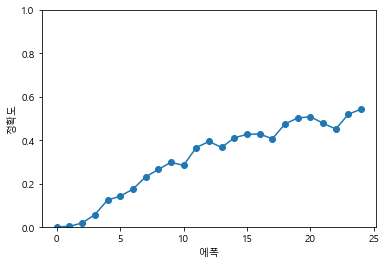

In [24]:
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:,::-1], x_test[:,::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

reverse_model = seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(reverse_model,optimizer)

reverse_acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch = 1, batch_size=batch_size, max_grad=max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i <10
        correct_num += eval_seq2seq(reverse_model, question, correct, id_to_char, verbose, is_reverse=False)
    
    acc = float(correct_num)/len(x_test)
    reverse_acc_list.append(acc)
    print('검증 정확도 %.3f%%'%(acc*100))
    
x_reverse = np.arange(len(reverse_acc_list))
plt.plot(x, reverse_acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

#### peeky + reverse method

In [25]:
class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V,D,H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V,D)/100).astype('f')
        lstm_Wx = (rn(H+D,4*H)/np.sqrt(H+D)).astype('f')
        lstm_Wh = (rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (rn(H+H,V)/np.sqrt(H+H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)
        
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None
        
    def forward(self, xs, h):
        N,T = xs.shape
        N,H = h.shape
        
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        hs = np.repeat(h,T,axis=0).reshape(N,T,H)
        out = np.concatenate((hs,out),axis=2)
        
        out = self.lstm.forward(out)
        out = np.concatenate((hs,out),axis=2)
        
        score = self.affine.forward(out)
        self.cache = H
        return score
    
    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.48
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 2[s] | 손실 1.99
| 에폭 1 |  반복 81 / 351 | 시간 3[s] | 손실 1.89
| 에폭 1 |  반복 101 / 351 | 시간 3[s] | 손실 1.82
| 에폭 1 |  반복 121 / 351 | 시간 4[s] | 손실 1.82
| 에폭 1 |  반복 141 / 351 | 시간 5[s] | 손실 1.80
| 에폭 1 |  반복 161 / 351 | 시간 5[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 6[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 7[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 8[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 8[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 9[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 10[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 11[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 11[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 12[s] | 손실 1.73
Q   58+77
T 162 
X 100 
---
Q 461+579
T 1139
X 1013
---
Q  48+285
T 666 
X 102 
---
Q   551+8
T 163 
X 100 
---
Q  55+763
T 422 
X 1023
---
Q 752+006
T 857 
X 1023
---
Q 292+167
T 1053
X 1023
---
Q 795+038
T 1427
X 1111
---
Q  8

| 에폭 8 |  반복 341 / 351 | 시간 13[s] | 손실 0.34
Q   58+77
T 162 
X 161 
---
Q 461+579
T 1139
O 1139
---
Q  48+285
T 666 
X 657 
---
Q   551+8
T 163 
X 155 
---
Q  55+763
T 422 
O 422 
---
Q 752+006
T 857 
O 857 
---
Q 292+167
T 1053
O 1053
---
Q 795+038
T 1427
X 1438
---
Q  838+62
T 864 
O 864 
---
Q  39+341
T 236 
O 236 
---
검증 정확도 65.060%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.32
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 0.31
| 에폭 9 |  반복 41 / 351 | 시간 1[s] | 손실 0.31
| 에폭 9 |  반복 61 / 351 | 시간 2[s] | 손실 0.31
| 에폭 9 |  반복 81 / 351 | 시간 3[s] | 손실 0.29
| 에폭 9 |  반복 101 / 351 | 시간 4[s] | 손실 0.29
| 에폭 9 |  반복 121 / 351 | 시간 4[s] | 손실 0.29
| 에폭 9 |  반복 141 / 351 | 시간 5[s] | 손실 0.27
| 에폭 9 |  반복 161 / 351 | 시간 6[s] | 손실 0.27
| 에폭 9 |  반복 181 / 351 | 시간 7[s] | 손실 0.26
| 에폭 9 |  반복 201 / 351 | 시간 8[s] | 손실 0.25
| 에폭 9 |  반복 221 / 351 | 시간 8[s] | 손실 0.25
| 에폭 9 |  반복 241 / 351 | 시간 9[s] | 손실 0.24
| 에폭 9 |  반복 261 / 351 | 시간 10[s] | 손실 0.24
| 에폭 9 |  반복 281 / 351 | 시간 11[s] | 손실 0.23
| 에폭 9 |  반복 301 / 3

| 에폭 16 |  반복 141 / 351 | 시간 5[s] | 손실 0.04
| 에폭 16 |  반복 161 / 351 | 시간 6[s] | 손실 0.04
| 에폭 16 |  반복 181 / 351 | 시간 7[s] | 손실 0.04
| 에폭 16 |  반복 201 / 351 | 시간 8[s] | 손실 0.04
| 에폭 16 |  반복 221 / 351 | 시간 9[s] | 손실 0.03
| 에폭 16 |  반복 241 / 351 | 시간 9[s] | 손실 0.04
| 에폭 16 |  반복 261 / 351 | 시간 10[s] | 손실 0.05
| 에폭 16 |  반복 281 / 351 | 시간 11[s] | 손실 0.05
| 에폭 16 |  반복 301 / 351 | 시간 12[s] | 손실 0.04
| 에폭 16 |  반복 321 / 351 | 시간 13[s] | 손실 0.04
| 에폭 16 |  반복 341 / 351 | 시간 13[s] | 손실 0.04
Q   58+77
T 162 
O 162 
---
Q 461+579
T 1139
O 1139
---
Q  48+285
T 666 
O 666 
---
Q   551+8
T 163 
O 163 
---
Q  55+763
T 422 
O 422 
---
Q 752+006
T 857 
O 857 
---
Q 292+167
T 1053
O 1053
---
Q 795+038
T 1427
O 1427
---
Q  838+62
T 864 
O 864 
---
Q  39+341
T 236 
O 236 
---
검증 정확도 95.940%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.05
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.04
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.03
| 에폭 17 |  반복 61 / 351 | 시간 2[s] | 손실 0.03
| 에폭 17 |  반복 81 / 351 | 시간 3[s] | 손실 0.03
| 

검증 정확도 94.060%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.03
| 에폭 24 |  반복 21 / 351 | 시간 0[s] | 손실 0.03
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.03
| 에폭 24 |  반복 61 / 351 | 시간 2[s] | 손실 0.04
| 에폭 24 |  반복 81 / 351 | 시간 3[s] | 손실 0.04
| 에폭 24 |  반복 101 / 351 | 시간 4[s] | 손실 0.04
| 에폭 24 |  반복 121 / 351 | 시간 4[s] | 손실 0.04
| 에폭 24 |  반복 141 / 351 | 시간 5[s] | 손실 0.04
| 에폭 24 |  반복 161 / 351 | 시간 6[s] | 손실 0.03
| 에폭 24 |  반복 181 / 351 | 시간 7[s] | 손실 0.02
| 에폭 24 |  반복 201 / 351 | 시간 8[s] | 손실 0.02
| 에폭 24 |  반복 221 / 351 | 시간 9[s] | 손실 0.03
| 에폭 24 |  반복 241 / 351 | 시간 9[s] | 손실 0.02
| 에폭 24 |  반복 261 / 351 | 시간 10[s] | 손실 0.02
| 에폭 24 |  반복 281 / 351 | 시간 11[s] | 손실 0.02
| 에폭 24 |  반복 301 / 351 | 시간 12[s] | 손실 0.02
| 에폭 24 |  반복 321 / 351 | 시간 13[s] | 손실 0.02
| 에폭 24 |  반복 341 / 351 | 시간 13[s] | 손실 0.02
Q   58+77
T 162 
O 162 
---
Q 461+579
T 1139
O 1139
---
Q  48+285
T 666 
O 666 
---
Q   551+8
T 163 
O 163 
---
Q  55+763
T 422 
O 422 
---
Q 752+006
T 857 
O 857 
---
Q 292+167
T 1053
O 1053
--

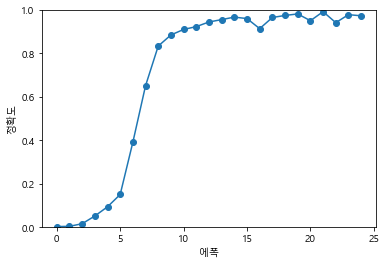

In [26]:
class Peekyseq2seq(seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V,D,H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V,D,H)
        self.decoder = PeekyDecoder(V,D,H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads  = self.encoder.grads + self.decoder.grads

        
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:,::-1], x_test[:,::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

peeky_model = Peekyseq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(peeky_model,optimizer)

peeky_acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch = 1, batch_size=batch_size, max_grad=max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i <10
        correct_num += eval_seq2seq(peeky_model, question, correct, id_to_char, verbose, is_reverse=False)
    
    acc = float(correct_num)/len(x_test)
    peeky_acc_list.append(acc)
    print('검증 정확도 %.3f%%'%(acc*100))
    
x_peeky = np.arange(len(peeky_acc_list))
plt.plot(x, peeky_acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

#### only peeky method

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.49
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 2[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.84
| 에폭 1 |  반복 101 / 351 | 시간 3[s] | 손실 1.80
| 에폭 1 |  반복 121 / 351 | 시간 4[s] | 손실 1.79
| 에폭 1 |  반복 141 / 351 | 시간 5[s] | 손실 1.77
| 에폭 1 |  반복 161 / 351 | 시간 5[s] | 손실 1.77
| 에폭 1 |  반복 181 / 351 | 시간 6[s] | 손실 1.76
| 에폭 1 |  반복 201 / 351 | 시간 7[s] | 손실 1.76
| 에폭 1 |  반복 221 / 351 | 시간 8[s] | 손실 1.75
| 에폭 1 |  반복 241 / 351 | 시간 8[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 9[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 10[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 11[s] | 손실 1.73
| 에폭 1 |  반복 321 / 351 | 시간 11[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 12[s] | 손실 1.73
Q 77+85  
T 162 
X 107 
---
Q 975+164
T 1139
X 1011
---
Q 582+84 
T 666 
X 103 
---
Q 8+155  
T 163 
X 101 
---
Q 367+55 
T 422 
X 103 
---
Q 600+257
T 857 
X 1023
---
Q 761+292
T 1053
X 1023
---
Q 830+597
T 1427
X 1011
---
Q 26

| 에폭 8 |  반복 341 / 351 | 시간 13[s] | 손실 0.71
Q 77+85  
T 162 
X 164 
---
Q 975+164
T 1139
X 1137
---
Q 582+84 
T 666 
X 665 
---
Q 8+155  
T 163 
X 160 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 849 
---
Q 761+292
T 1053
X 1037
---
Q 830+597
T 1427
X 1437
---
Q 26+838 
T 864 
X 869 
---
Q 143+93 
T 236 
X 231 
---
검증 정확도 12.480%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.70
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 0.70
| 에폭 9 |  반복 41 / 351 | 시간 1[s] | 손실 0.70
| 에폭 9 |  반복 61 / 351 | 시간 2[s] | 손실 0.70
| 에폭 9 |  반복 81 / 351 | 시간 3[s] | 손실 0.70
| 에폭 9 |  반복 101 / 351 | 시간 3[s] | 손실 0.69
| 에폭 9 |  반복 121 / 351 | 시간 4[s] | 손실 0.69
| 에폭 9 |  반복 141 / 351 | 시간 5[s] | 손실 0.68
| 에폭 9 |  반복 161 / 351 | 시간 6[s] | 손실 0.68
| 에폭 9 |  반복 181 / 351 | 시간 7[s] | 손실 0.67
| 에폭 9 |  반복 201 / 351 | 시간 8[s] | 손실 0.68
| 에폭 9 |  반복 221 / 351 | 시간 8[s] | 손실 0.67
| 에폭 9 |  반복 241 / 351 | 시간 9[s] | 손실 0.67
| 에폭 9 |  반복 261 / 351 | 시간 10[s] | 손실 0.67
| 에폭 9 |  반복 281 / 351 | 시간 11[s] | 손실 0.66
| 에폭 9 |  반복 301 / 3

| 에폭 16 |  반복 141 / 351 | 시간 5[s] | 손실 0.44
| 에폭 16 |  반복 161 / 351 | 시간 6[s] | 손실 0.43
| 에폭 16 |  반복 181 / 351 | 시간 7[s] | 손실 0.43
| 에폭 16 |  반복 201 / 351 | 시간 8[s] | 손실 0.42
| 에폭 16 |  반복 221 / 351 | 시간 8[s] | 손실 0.43
| 에폭 16 |  반복 241 / 351 | 시간 9[s] | 손실 0.44
| 에폭 16 |  반복 261 / 351 | 시간 10[s] | 손실 0.43
| 에폭 16 |  반복 281 / 351 | 시간 11[s] | 손실 0.42
| 에폭 16 |  반복 301 / 351 | 시간 11[s] | 손실 0.43
| 에폭 16 |  반복 321 / 351 | 시간 12[s] | 손실 0.45
| 에폭 16 |  반복 341 / 351 | 시간 13[s] | 손실 0.44
Q 77+85  
T 162 
X 163 
---
Q 975+164
T 1139
X 1137
---
Q 582+84 
T 666 
X 667 
---
Q 8+155  
T 163 
X 162 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 856 
---
Q 761+292
T 1053
X 1048
---
Q 830+597
T 1427
X 1429
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 31.180%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.41
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.41
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.41
| 에폭 17 |  반복 61 / 351 | 시간 2[s] | 손실 0.42
| 에폭 17 |  반복 81 / 351 | 시간 3[s] | 손실 0.42
| 

검증 정확도 70.660%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.18
| 에폭 24 |  반복 21 / 351 | 시간 0[s] | 손실 0.18
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.18
| 에폭 24 |  반복 61 / 351 | 시간 2[s] | 손실 0.18
| 에폭 24 |  반복 81 / 351 | 시간 3[s] | 손실 0.17
| 에폭 24 |  반복 101 / 351 | 시간 3[s] | 손실 0.18
| 에폭 24 |  반복 121 / 351 | 시간 4[s] | 손실 0.17
| 에폭 24 |  반복 141 / 351 | 시간 5[s] | 손실 0.17
| 에폭 24 |  반복 161 / 351 | 시간 6[s] | 손실 0.17
| 에폭 24 |  반복 181 / 351 | 시간 6[s] | 손실 0.18
| 에폭 24 |  반복 201 / 351 | 시간 7[s] | 손실 0.18
| 에폭 24 |  반복 221 / 351 | 시간 8[s] | 손실 0.17
| 에폭 24 |  반복 241 / 351 | 시간 9[s] | 손실 0.18
| 에폭 24 |  반복 261 / 351 | 시간 10[s] | 손실 0.18
| 에폭 24 |  반복 281 / 351 | 시간 10[s] | 손실 0.17
| 에폭 24 |  반복 301 / 351 | 시간 11[s] | 손실 0.17
| 에폭 24 |  반복 321 / 351 | 시간 12[s] | 손실 0.16
| 에폭 24 |  반복 341 / 351 | 시간 13[s] | 손실 0.16
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
X 164 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
X 1054
--

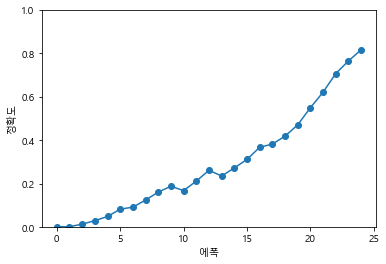

In [27]:
from dataset2 import sequence

class Peekyseq2seq(seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V,D,H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V,D,H)
        self.decoder = PeekyDecoder(V,D,H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads  = self.encoder.grads + self.decoder.grads

        
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

is_reverse = False
if is_reverse:
    x_train, x_test = x_train[:,::-1], x_test[:,::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

peeky_model = Peekyseq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(peeky_model,optimizer)

only_peeky_acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch = 1, batch_size=batch_size, max_grad=max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i <10
        correct_num += eval_seq2seq(peeky_model, question, correct, id_to_char, verbose, is_reverse=False)
    
    acc = float(correct_num)/len(x_test)
    only_peeky_acc_list.append(acc)
    print('검증 정확도 %.3f%%'%(acc*100))
    
x_only_peeky = np.arange(len(only_peeky_acc_list))
plt.plot(x, only_peeky_acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

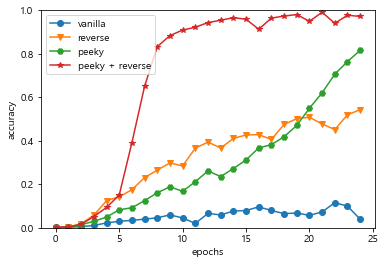

In [31]:
plt.plot(x, acc_list, marker='o')
plt.plot(x_reverse, reverse_acc_list, marker='v')
plt.plot(x_only_peeky, only_peeky_acc_list, marker='H')
plt.plot(x_peeky, peeky_acc_list, marker='*')

plt.legend(['vanilla', 'reverse', 'peeky','peeky + reverse'], loc='upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()